[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-418239892.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A, B, D = map(float, coef)


Generation 1: Best SAD = 3.1976
Generation 2: Best SAD = 3.1761
Generation 3: Best SAD = 3.1756
Generation 4: Best SAD = 3.1755
Generation 5: Best SAD = 3.1755
Generation 6: Best SAD = 3.1755
Generation 7: Best SAD = 3.1755
Generation 8: Best SAD = 3.1755
Generation 9: Best SAD = 3.1755
Generation 10: Best SAD = 3.1755

Best Linear LPPL Parameters
A=5.596244, B=-0.010886, C=-0.126432
beta=0.708407, omega=6.170088, phi=1.228384, tc=140
SAD=3.175548


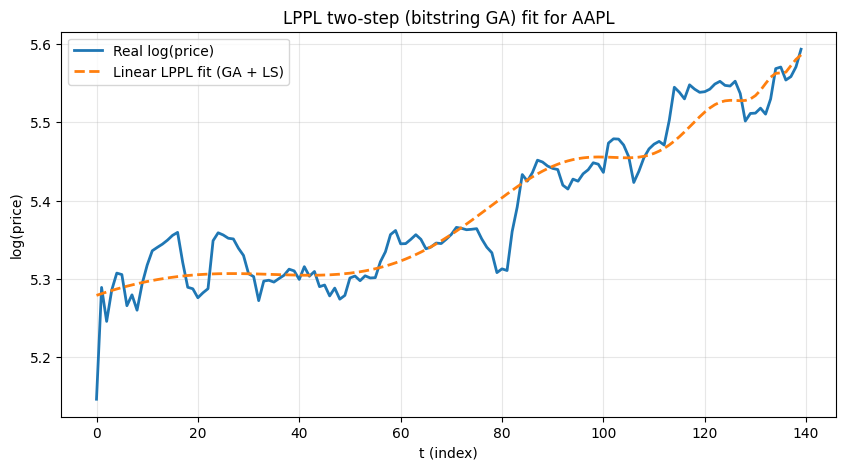

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ============ STEP 1: 下載股價資料 ============
ticker = "AAPL"
start_date = "2025-04-08"
end_date   = "2025-10-28"

# 下載調整後股價
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# 用 log 價格做 LPPL
price = np.log(data["Close"].values)

T = len(price)
t = np.arange(T)      # t = 0, 1, ..., T-1
tc = T                # 假設崩盤時間在最後一天「之後一點點」（index T）

np.random.seed(42)

# ============ STEP 2: 建 f1, f2 ============
# tau = tc - t
# f1 = tau^beta
# f2 = tau^beta * cos(omega * ln(tau) + phi)
def build_f1_f2(t, tc, beta, omega, phi):
    # 在這裡 tc > max(t)，所以 tc - t 至少是 1，不會有 log(0) 問題
    tau = tc - t
    f1 = tau ** beta
    f2 = f1 * np.cos(omega * np.log(tau) + phi)
    return f1, f2

# ============ STEP 3: 給定 beta, omega, phi，線性代數解 A, B, C ============
# 價格近似： price ≈ A + B f1 + D f2, 其中 D = B*C
def solve_ABC_from_linear(price, t, tc, beta, omega, phi):
    f1, f2 = build_f1_f2(t, tc, beta, omega, phi)

    # X: N×3 矩陣 [1, f1, f2]
    X = np.column_stack([np.ones_like(price), f1, f2])

    # 最小平方法解 [A, B, D]
    coef, _, _, _ = np.linalg.lstsq(X, price, rcond=None)
    A, B, D = map(float, coef)

    # D = B*C → C = D/B
    if abs(B) < 1e-12:
        C = 0.0
    else:
        C = D / B

    # 線性 LPPL 的預測 log 價格
    pred = X @ coef   # 等同於 A + B*f1 + D*f2

    # SAD = Σ |真實 - 預測|
    sad = float(np.sum(np.abs(price - pred)))
    return sad, A, B, C, pred

# ============ STEP 4: SAD(beta, omega, phi)（給 GA 用的 fitness） ============
def SAD(beta, omega, phi):
    beta  = float(beta)
    omega = float(omega)
    phi   = float(phi)

    sad, A, B, C, pred = solve_ABC_from_linear(price, t, tc, beta, omega, phi)
    return sad, (A, B, C, pred)

# ============ STEP 5: Genetic Algorithm（bitstring 架構） ============

# 為了先測試不要太慢，先用小一點的 GA 參數
p = 1000          # population size（原本 5000，可以之後再調回去）
r = 0.01          # survival rate
m = 100           # mutation count per generation（原本 200）
generation = 10   # number of generations（原本 15）
survive = max(1, round(p * r))
gene_len = 30     # 10 bits per parameter (beta, omega, phi)

# gene -> (beta, omega, phi)
def gene2params(gene):
    # gene: shape (30,) 的 0/1 陣列
    s1 = np.sum(2**np.arange(10) * gene[0:10])
    s2 = np.sum(2**np.arange(10) * gene[10:20])
    s3 = np.sum(2**np.arange(10) * gene[20:30])

    # 把 0~1023 映射到連續參數範圍
    beta  = 0.1 + float(s1) / (2**10 - 1) * 0.8          # β ∈ [0.1, 0.9]
    omega = 4.0 + float(s2) / (2**10 - 1) * 15.0         # ω ∈ [4, 19]
    phi   = float(s3) / (2**10 - 1) * (2.0 * np.pi)      # φ ∈ [0, 2π]
    return beta, omega, phi

# 初始化族群
rng = np.random.default_rng()
pop = rng.integers(0, 2, size=(p, gene_len), dtype=np.int8)  # (p, 30) 0/1
fit = np.zeros((p,), dtype=float)                            # (p,)

# GA 主迴圈
for g in range(generation):
    # 1. 計算所有個體的 fitness（SAD）
    for i in range(p):
        beta, omega, phi = gene2params(pop[i, :])
        sad, _ = SAD(beta, omega, phi)
        fit[i] = sad

    # 2. 依照 SAD 排序（越小越好）
    order = np.argsort(fit)
    pop = pop[order, :]
    fit = fit[order]

    print(f"Generation {g+1}: Best SAD = {fit[0]:.4f}")

    # 3. crossover：用前 survive 名當父母，產生剩下的個體
    for i in range(survive, p):
        fid = rng.integers(0, survive)
        mid = rng.integers(0, survive)
        while mid == fid:
            mid = rng.integers(0, survive)

        mask = rng.integers(0, 2, size=(gene_len,), dtype=np.int8)
        child = pop[mid, :].copy()
        father = pop[fid, :]
        child[mask == 1] = father[mask == 1]
        pop[i, :] = child

    # 4. mutation：對部分基因做 bit flip
    for _ in range(m):
        r_idx = rng.integers(survive, p)   # 只突變小孩那一段
        c_idx = rng.integers(0, gene_len)
        pop[r_idx, c_idx] ^= 1            # 0 ↔ 1

# ============ STEP 6: 取最佳基因，重算 A,B,C 並畫圖 ============

# 最後一代裡，已經照 fit 排序，pop[0] 就是最佳基因
beta, omega, phi = gene2params(pop[0, :])
best_sad, (A, B, C, pred) = SAD(beta, omega, phi)

print("\nBest Linear LPPL Parameters")
print(f"A={A:.6f}, B={B:.6f}, C={C:.6f}")
print(f"beta={beta:.6f}, omega={omega:.6f}, phi={phi:.6f}, tc={tc}")
print(f"SAD={best_sad:.6f}")

# 畫實際 log 價格 vs LPPL 擬合
plt.figure(figsize=(10, 5))
plt.plot(t, price, label="Real log(price)", lw=2)
plt.plot(t, pred, "--", label="Linear LPPL fit (GA + LS)", lw=2)
plt.xlabel("t (index)")
plt.ylabel("log(price)")
plt.title(f"LPPL two-step (bitstring GA) fit for {ticker}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
